<h1>Comparison of Transfer Learning Models - Frontal View </h1>

<hr>

<p>Within TensorFlow, there are 71 architectures available for Transfer Learning. From these, we have selected 12 for evaluation, testing each over the course of just 5 epochs. We plot a graph to illustrate the relationship between accuracy and the number of parameters within each model. Our objective is to identify a model that minimizes the number of parameters required, while simultaneously maximizing accuracy. It's important to note that, at present, we are not employing any form of data augmentations.</p>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import inspect
import glob
import os
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import pandas as pd
import inspect
from tqdm import tqdm
from keras.preprocessing import image
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import drive

from sklearn.model_selection import StratifiedKFold

In [ ]:
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 32
data_path = "/content/drive/MyDrive/sve_F-bez augumentacije/Train"
n_folds =5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_files = glob.glob(os.path.join(data_path, '*/*'))
labels = [os.path.basename(os.path.dirname(fp)) for fp in all_files]

In [ ]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
len(model_dictionary)

71

In [ ]:
new_model_dict = {key: model_dictionary[key] for key in model_dictionary  if key in ['MobileNetV2', 'MobileNet', 'EfficientNetB0', 'DenseNet121','VGG16', 'VGG19', 'Xception', 'InceptionV3','ResNet50V2','ResNet50', 'ResNet101V2', 'ResNet101']}

In [ ]:
len(new_model_dict)

12

In [ ]:
def preprocess_data_for_fold(train_files, val_files, img_size):
    datagen = image.ImageDataGenerator(rescale=1./255.)

    # Extracting the labels from the directory structure
    train_labels = [os.path.basename(os.path.dirname(fp)) for fp in train_files]
    val_labels = [os.path.basename(os.path.dirname(fp)) for fp in val_files]

    train_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        directory=None,
        x_col="filename",
        y_col="class",
        class_mode="binary",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        directory=None,
        x_col="filename",
        y_col="class",
        class_mode="binary",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    return train_gen, val_gen


In [ ]:
def test_preprocces(img_size):
  test_datagen = image.ImageDataGenerator(rescale=1./255.)
  test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/sve_F-bez augumentacije/Test",
                                        target_size=img_size,
                                        class_mode='binary',
                                        batch_size=batch_size,
                                        shuffle=False)
  return test_generator

In [ ]:
def build_model(model_1,input_shape):
    pre_trained_model = model_1(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    model = tf.keras.models.Sequential()
    model.add(pre_trained_model)
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': [], 'test_accuracy': []}
for model_name, model_1 in tqdm(list(new_model_dict.items())[:6]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)

    fold_no = 1
    all_acc = []
    all_loss = []

    for train_indices, val_indices in kfold.split(all_files,labels):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

    # Preprocess data and build model (assuming these functions are defined)
        train_files = [all_files[i] for i in train_indices]
        val_files = [all_files[i] for i in val_indices]
        if 'NASNetLarge' in model_name:
          img_size =(331,331)
          input_shape =(331,331,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)
        elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
          img_size=(299,299)
          input_shape=(299,299,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)
        else:
          img_size=(224,224)
          input_shape=(224,224,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)


        model = build_model(model_1,input_shape)

    # Fit data to model
        history = model.fit(train_gen, epochs=5, validation_data=val_gen)

    # Evaluate the model on validation set
        scores = model.evaluate(val_gen, verbose=0)
        print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {round(scores[1]*100, 2)}%')
        all_acc.append(scores[1] * 100)
        all_loss.append(scores[0])

    # Increase fold number
        fold_no += 1

# Provide average scores
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(len(all_acc)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {all_loss[i]} - Accuracy: {all_acc[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(all_acc)} (+- {np.std(all_acc)})')
    print(f'> Loss: {np.mean(all_loss)}')
    print('------------------------------------------------------------------------')
    if 'NASNetLarge' in model_name:
        test_processed = test_preprocces(img_size)
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        test_processed = test_preprocces(img_size)
    else:
        test_processed = test_preprocces(img_size)

    test_acc = model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(model.count_params())
    model_benchmarks['validation_accuracy'].append(np.mean(all_acc))
    model_benchmarks['test_accuracy'].append(test_acc[-1])


  0%|          | 0/6 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 48s 8s/step - loss: 0.6904 - accuracy: 0.4960 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 565ms/step - loss: 0.6660 - accuracy: 0.6240 - val_loss: 0.6660 - val_accuracy: 0.5312
Epoch 3/5
4/4 [==============================] - 2s 496ms/step - loss: 0.6477 - accuracy: 0.6480 - val_loss: 0.6510 - val_accuracy: 0.6250
Epoch 4/5
4/4 [==============================] - 2s 469ms/step - loss: 0.6409 - accuracy: 0.7040 - val_loss: 0.6430 - val_accuracy: 0.6562
Epoch 5/5
4/4 [==============================] - 2s 462ms/step - loss: 0.6348 - accuracy: 0.6560 - val_loss: 0.6332 - val_accuracy: 0.7188
Score for fold 1: Loss of 

 17%|█▋        | 1/6 [04:10<20:53, 250.78s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 15s 2s/step - loss: 0.7001 - accuracy: 0.4960 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 435ms/step - loss: 0.6982 - accuracy: 0.4960 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 2s 455ms/step - loss: 0.7025 - accuracy: 0.4960 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 2s 508ms/step - loss: 0.7040 - accuracy: 0.4000 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 2s 559ms/step - loss: 0.6961 - accuracy: 0.5040 - val_loss: 0.6953 - val_accuracy: 0.5000
Score for fold 1: Loss of 

 33%|███▎      | 2/6 [06:20<11:57, 179.46s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 16s 2s/step - loss: 0.6962 - accuracy: 0.5360 - val_loss: 0.6878 - val_accuracy: 0.5312
Epoch 2/5
4/4 [==============================] - 2s 408ms/step - loss: 0.6638 - accuracy: 0.6080 - val_loss: 0.6396 - val_accuracy: 0.7500
Epoch 3/5
4/4 [==============================] - 2s 438ms/step - loss: 0.6276 - accuracy: 0.6480 - val_loss: 0.6204 - val_accuracy: 0.6875
Epoch 4/5
4/4 [==============================] - 2s 533ms/step - loss: 0.6050 - accuracy: 0.7200 - val_loss: 0.5941 - val_accuracy: 0.7812
Epoch 5/5
4/4 [==============================] - 2s 601ms/step - loss: 0.5694 - accuracy: 0.7840 - val_loss: 0.5718 - val_accuracy: 0.8438
Score for fold 1: Loss of 

 50%|█████     | 3/6 [08:34<07:55, 158.61s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 6s 898ms/step - loss: 0.7333 - accuracy: 0.4560 - val_loss: 0.6968 - val_accuracy: 0.5938
Epoch 2/5
4/4 [==============================] - 2s 516ms/step - loss: 0.7086 - accuracy: 0.5120 - val_loss: 0.6632 - val_accuracy: 0.5625
Epoch 3/5
4/4 [==============================] - 2s 427ms/step - loss: 0.6758 - accuracy: 0.5920 - val_loss: 0.6445 - val_accuracy: 0.5625
Epoch 4/5
4/4 [==============================] - 2s 414ms/step - loss: 0.6524 - accuracy: 0.6560 - val_loss: 0.6210 - val_accuracy: 0.7188
Epoch 5/5
4/4 [==============================] - 2s 405ms/step - loss: 0.6330 - accuracy: 0.7200 - val_loss: 0.5997 - val_accuracy: 0.8125
Score for fold 1: Loss of 0.5997372269630432; Accuracy of 81.25%
------------------------------------------------------------------------
Training for fold 2 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated

Epoch 1/5
4/4 [==============================] - 5s 834ms/step - loss: 0.6784 - accuracy: 0.5600 - val_loss: 0.6711 - val_accuracy: 0.6562
Epoch 2/5
4/4 [==============================] - 2s 520ms/step - loss: 0.6594 - accuracy: 0.5360 - val_loss: 0.6643 - val_accuracy: 0.6250
Epoch 3/5
4/4 [==============================] - 2s 422ms/step - loss: 0.6294 - accuracy: 0.6400 - val_loss: 0.6449 - val_accuracy: 0.5938
Epoch 4/5
4/4 [==============================] - 2s 437ms/step - loss: 0.6048 - accuracy: 0.7920 - val_loss: 0.6395 - val_accuracy: 0.5938
Epoch 5/5
4/4 [==============================] - 2s 412ms/step - loss: 0.5951 - accuracy: 0.7040 - val_loss: 0.6295 - val_accuracy: 0.6875
Score for fold 2: Loss of 0.6294859647750854; Accuracy of 68.75%
------------------------------------------------------------------------
Training for fold 3 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 7s 1s/step - loss: 0.6824 - accuracy: 0.5952 - val_loss: 0.7097 - val_accuracy: 0.4516
Epoch 2/5
4/4 [==============================] - 2s 397ms/step - loss: 0.6514 - accuracy: 0.6429 - val_loss: 0.7025 - val_accuracy: 0.4194
Epoch 3/5
4/4 [==============================] - 2s 413ms/step - loss: 0.6268 - accuracy: 0.6667 - val_loss: 0.6900 - val_accuracy: 0.4839
Epoch 4/5
4/4 [==============================] - 2s 416ms/step - loss: 0.6011 - accuracy: 0.7222 - val_loss: 0.6704 - val_accuracy: 0.5484
Epoch 5/5
4/4 [==============================] - 2s 399ms/step - loss: 0.5808 - accuracy: 0.7540 - val_loss: 0.6637 - val_accuracy: 0.6129
Score for fold 3: Loss of 0.6637435555458069; Accuracy of 61.29%
------------------------------------------------------------------------
Training for fold 4 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 5s 795ms/step - loss: 0.7080 - accuracy: 0.4921 - val_loss: 0.6950 - val_accuracy: 0.5161
Epoch 2/5
4/4 [==============================] - 2s 412ms/step - loss: 0.6923 - accuracy: 0.5476 - val_loss: 0.6747 - val_accuracy: 0.5484
Epoch 3/5
4/4 [==============================] - 2s 415ms/step - loss: 0.6662 - accuracy: 0.5238 - val_loss: 0.6510 - val_accuracy: 0.5161
Epoch 4/5
4/4 [==============================] - 2s 409ms/step - loss: 0.6445 - accuracy: 0.6429 - val_loss: 0.6346 - val_accuracy: 0.7097
Epoch 5/5
4/4 [==============================] - 2s 416ms/step - loss: 0.6231 - accuracy: 0.6667 - val_loss: 0.6211 - val_accuracy: 0.6774
Score for fold 4: Loss of 0.6210599541664124; Accuracy of 67.74%
------------------------------------------------------------------------
Training for fold 5 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 5s 623ms/step - loss: 0.7243 - accuracy: 0.5397 - val_loss: 0.7491 - val_accuracy: 0.3871
Epoch 2/5
4/4 [==============================] - 2s 406ms/step - loss: 0.6833 - accuracy: 0.5079 - val_loss: 0.7255 - val_accuracy: 0.4516
Epoch 3/5
4/4 [==============================] - 2s 410ms/step - loss: 0.6524 - accuracy: 0.6270 - val_loss: 0.7012 - val_accuracy: 0.5161
Epoch 4/5
4/4 [==============================] - 2s 384ms/step - loss: 0.6325 - accuracy: 0.6825 - val_loss: 0.6857 - val_accuracy: 0.4839
Epoch 5/5
4/4 [==============================] - 2s 416ms/step - loss: 0.6172 - accuracy: 0.6905 - val_loss: 0.6721 - val_accuracy: 0.5806
Score for fold 5: Loss of 0.6721315979957581; Accuracy of 58.06%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5997372269630432 - Accuracy: 81.25%
------------------------

 67%|██████▋   | 4/6 [09:54<04:15, 127.91s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 7s 1s/step - loss: 0.8416 - accuracy: 0.4960 - val_loss: 0.7515 - val_accuracy: 0.4375
Epoch 2/5
4/4 [==============================] - 2s 511ms/step - loss: 0.6942 - accuracy: 0.5280 - val_loss: 0.7746 - val_accuracy: 0.4688
Epoch 3/5
4/4 [==============================] - 2s 460ms/step - loss: 0.7224 - accuracy: 0.4960 - val_loss: 0.7496 - val_accuracy: 0.4688
Epoch 4/5
4/4 [==============================] - 2s 512ms/step - loss: 0.6874 - accuracy: 0.5200 - val_loss: 0.7015 - val_accuracy: 0.5312
Epoch 5/5
4/4 [==============================] - 2s 612ms/step - loss: 0.6591 - accuracy: 0.6560 - val_loss: 0.6889 - val_accuracy: 0.5625
Score for fold 1: Loss of 0.6889300346374512; Accuracy of 56.25%
------------------------------------------------------------------------
Training for fold 2 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated imag

Epoch 1/5
4/4 [==============================] - 5s 742ms/step - loss: 0.7342 - accuracy: 0.4320 - val_loss: 0.7205 - val_accuracy: 0.4375
Epoch 2/5
4/4 [==============================] - 2s 430ms/step - loss: 0.7017 - accuracy: 0.4720 - val_loss: 0.7037 - val_accuracy: 0.5312
Epoch 3/5
4/4 [==============================] - 2s 593ms/step - loss: 0.6862 - accuracy: 0.5440 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 2s 577ms/step - loss: 0.6598 - accuracy: 0.6480 - val_loss: 0.6760 - val_accuracy: 0.5938
Epoch 5/5
4/4 [==============================] - 2s 427ms/step - loss: 0.6352 - accuracy: 0.6800 - val_loss: 0.6624 - val_accuracy: 0.6562
Score for fold 2: Loss of 0.6624141931533813; Accuracy of 65.62%
------------------------------------------------------------------------
Training for fold 3 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 7s 975ms/step - loss: 0.7497 - accuracy: 0.3889 - val_loss: 0.7092 - val_accuracy: 0.4516
Epoch 2/5
4/4 [==============================] - 2s 520ms/step - loss: 0.7067 - accuracy: 0.4921 - val_loss: 0.6896 - val_accuracy: 0.5484
Epoch 3/5
4/4 [==============================] - 2s 407ms/step - loss: 0.6855 - accuracy: 0.5238 - val_loss: 0.6799 - val_accuracy: 0.5806
Epoch 4/5
4/4 [==============================] - 2s 428ms/step - loss: 0.6667 - accuracy: 0.5714 - val_loss: 0.6540 - val_accuracy: 0.5806
Epoch 5/5
4/4 [==============================] - 2s 414ms/step - loss: 0.6441 - accuracy: 0.6825 - val_loss: 0.6379 - val_accuracy: 0.6452
Score for fold 3: Loss of 0.6378862857818604; Accuracy of 64.52%
------------------------------------------------------------------------
Training for fold 4 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 7s 775ms/step - loss: 0.7042 - accuracy: 0.5317 - val_loss: 0.6959 - val_accuracy: 0.6452
Epoch 2/5
4/4 [==============================] - 2s 419ms/step - loss: 0.6630 - accuracy: 0.6349 - val_loss: 0.6844 - val_accuracy: 0.6774
Epoch 3/5
4/4 [==============================] - 2s 424ms/step - loss: 0.6501 - accuracy: 0.6825 - val_loss: 0.6742 - val_accuracy: 0.4839
Epoch 4/5
4/4 [==============================] - 2s 436ms/step - loss: 0.6250 - accuracy: 0.7143 - val_loss: 0.6643 - val_accuracy: 0.5161
Epoch 5/5
4/4 [==============================] - 2s 417ms/step - loss: 0.6049 - accuracy: 0.7619 - val_loss: 0.6499 - val_accuracy: 0.7419
Score for fold 4: Loss of 0.6499075889587402; Accuracy of 74.19%
------------------------------------------------------------------------
Training for fold 5 ...
Found 126 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


Epoch 1/5
4/4 [==============================] - 6s 739ms/step - loss: 0.9060 - accuracy: 0.5000 - val_loss: 0.7120 - val_accuracy: 0.5161
Epoch 2/5
4/4 [==============================] - 2s 409ms/step - loss: 0.7228 - accuracy: 0.4524 - val_loss: 0.7430 - val_accuracy: 0.4839
Epoch 3/5
4/4 [==============================] - 2s 411ms/step - loss: 0.7325 - accuracy: 0.5000 - val_loss: 0.7507 - val_accuracy: 0.4839
Epoch 4/5
4/4 [==============================] - 2s 398ms/step - loss: 0.7040 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.4839
Epoch 5/5
4/4 [==============================] - 2s 497ms/step - loss: 0.6556 - accuracy: 0.5873 - val_loss: 0.6785 - val_accuracy: 0.5484
Score for fold 5: Loss of 0.678490161895752; Accuracy of 54.84%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6889300346374512 - Accuracy: 56.25%
-------------------------

 83%|████████▎ | 5/6 [11:24<01:54, 114.16s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/5
4/4 [==============================] - 17s 2s/step - loss: 0.7298 - accuracy: 0.4640 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 543ms/step - loss: 0.6967 - accuracy: 0.4800 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 3s 825ms/step - loss: 0.6986 - accuracy: 0.4960 - val_loss: 0.6964 - val_accuracy: 0.4375
Epoch 4/5
4/4 [==============================] - 2s 496ms/step - loss: 0.7025 - accuracy: 0.4880 - val_loss: 0.7046 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 2s 531ms/step - loss: 0.7011 - accuracy: 0.5200 - val_loss: 0.6967 - val_accuracy: 0.5000
Score for fold 1: Loss o

100%|██████████| 6/6 [14:00<00:00, 140.14s/it]


In [ ]:
for model_name, model_1 in tqdm(list(new_model_dict.items())[6:]):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)

    fold_no = 1
    all_acc = []
    all_loss = []

    for train_indices, val_indices in kfold.split(all_files,labels):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

    # Preprocess data and build model (assuming these functions are defined)
        train_files = [all_files[i] for i in train_indices]
        val_files = [all_files[i] for i in val_indices]
        if 'NASNetLarge' in model_name:
          img_size =(331,331)
          input_shape =(331,331,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)
        elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
          img_size=(299,299)
          input_shape=(299,299,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)
        else:
          img_size=(224,224)
          input_shape=(224,224,3)
          train_gen, val_gen = preprocess_data_for_fold(train_files, val_files, img_size)


        model = build_model(model_1,input_shape)

    # Fit data to model
        history = model.fit(train_gen, epochs=5, validation_data=val_gen)

    # Evaluate the model on validation set
        scores = model.evaluate(val_gen, verbose=0)
        fold_val_accuracy = round(scores[1] * 100, 2)
        print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {fold_val_accuracy}%')
        all_acc.append(fold_val_accuracy)
        all_loss.append(scores[0])

    # Increase fold number
        fold_no += 1

# Provide average scores
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(len(all_acc)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {all_loss[i]} - Accuracy: {all_acc[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(all_acc)} (+- {np.std(all_acc)})')
    print(f'> Loss: {np.mean(all_loss)}')
    print('------------------------------------------------------------------------')
    if 'NASNetLarge' in model_name:
        test_processed = test_preprocces(img_size)
    elif 'InceptionResNetV2' or 'InceptionV3' or 'Xception' in model_name:
        test_processed = test_preprocces(img_size)
    else:
        test_processed = test_preprocces(img_size)

    test_acc = model.evaluate(test_processed)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(model.count_params())
    model_benchmarks['validation_accuracy'].append(np.mean(all_acc))
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/6 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
171317808/171317808 [==============================] - 1s 0us/step
Epoch 1/5
4/4 [==============================] - 14s 2s/step - loss: 0.7337 - accuracy: 0.5280 - val_loss: 0.7228 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 492ms/step - loss: 0.6960 - accuracy: 0.5600 - val_loss: 0.6618 - val_accuracy: 0.5938
Epoch 3/5
4/4 [==============================] - 2s 486ms/step - loss: 0.6405 - accuracy: 0.6320 - val_loss: 0.6379 - val_accuracy: 0.7188
Epoch 4/5
4/4 [==============================] - 2s 466ms/step - loss: 0.6207 - accuracy: 0.6560 - val_loss: 0.6084 - val_accuracy: 0.7500
Epoch 5/5
4/4 [==============================] - 2s 585ms/step - loss: 0.5873 - accuracy: 0.7680 - val_loss: 0.5954 - val_accuracy: 0.7500
Score for fold 1: Loss o

 17%|█▋        | 1/6 [02:20<11:43, 140.69s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
4/4 [==============================] - 6s 824ms/step - loss: 0.9239 - accuracy: 0.5040 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 450ms/step - loss: 0.7119 - accuracy: 0.4800 - val_loss: 0.7503 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 2s 512ms/step - loss: 0.7572 - accuracy: 0.4960 - val_loss: 0.7376 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 2s 561ms/step - loss: 0.7281 - accuracy: 0.4960 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 2s 563ms/step - loss: 0.6963 - accuracy: 0.4480 - val_loss: 0.7003 - val_accuracy: 0.5000
Score for fold 1: Loss o

 33%|███▎      | 2/6 [03:56<07:37, 114.47s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 9s 1s/step - loss: 0.6958 - accuracy: 0.5760 - val_loss: 0.5931 - val_accuracy: 0.6250
Epoch 2/5
4/4 [==============================] - 2s 401ms/step - loss: 0.6518 - accuracy: 0.6320 - val_loss: 0.5691 - val_accuracy: 0.7188
Epoch 3/5
4/4 [==============================] - 2s 424ms/step - loss: 0.6107 - accuracy: 0.6960 - val_loss: 0.5178 - val_accuracy: 0.8125
Epoch 4/5
4/4 [==============================] - 2s 440ms/step - loss: 0.5873 - accuracy: 0.6800 - val_loss: 0.4956 - val_accuracy: 0.8125
Epoch 5/5
4/4 [==============================] - 2s 557ms/step - loss: 0.5590 - accuracy: 0.7360 - val_loss: 0.4868 - val_accuracy: 0.7500
Score for fold 1: Loss of 0

 50%|█████     | 3/6 [05:39<05:26, 108.95s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 20s 3s/step - loss: 0.6918 - accuracy: 0.5200 - val_loss: 0.6985 - val_accuracy: 0.4688
Epoch 2/5
4/4 [==============================] - 2s 563ms/step - loss: 0.6895 - accuracy: 0.5360 - val_loss: 0.6964 - val_accuracy: 0.4375
Epoch 3/5
4/4 [==============================] - 2s 581ms/step - loss: 0.6904 - accuracy: 0.5840 - val_loss: 0.6949 - val_accuracy: 0.4375
Epoch 4/5
4/4 [==============================] - 2s 502ms/step - loss: 0.6869 - accuracy: 0.5920 - val_loss: 0.6931 - val_accuracy: 0.5625
Epoch 5/5
4/4 [==============================] - 2s 490ms/step - loss: 0.6856 - accuracy: 0.5840 - val_loss: 0.6917 - val_accuracy: 0.5000
Score for fold 1: Loss of 

 67%|██████▋   | 4/6 [07:24<03:35, 107.66s/it]

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 4s 699ms/step - loss: 0.7715 - accuracy: 0.5040 - val_loss: 0.7457 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 2s 593ms/step - loss: 0.7256 - accuracy: 0.5040 - val_loss: 0.7162 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 2s 528ms/step - loss: 0.7096 - accuracy: 0.5040 - val_loss: 0.7030 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 2s 501ms/step - loss: 0.7008 - accuracy: 0.4160 - val_loss: 0.7017 - val_accuracy: 0.4688
Epoch 5/5
4/4 [==============================] - 2s 499ms/step - loss: 0.7037 - accuracy: 0.4800 - val_loss: 0.7034 - val_accuracy: 0.5000
Score for fold 1: Loss o

 83%|████████▎ | 5/6 [08:48<01:39, 99.14s/it] 

------------------------------------------------------------------------
Training for fold 1 ...
Found 125 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/5
4/4 [==============================] - 14s 2s/step - loss: 0.6853 - accuracy: 0.5120 - val_loss: 0.6313 - val_accuracy: 0.7188
Epoch 2/5
4/4 [==============================] - 2s 482ms/step - loss: 0.6577 - accuracy: 0.6080 - val_loss: 0.6035 - val_accuracy: 0.8750
Epoch 3/5
4/4 [==============================] - 2s 466ms/step - loss: 0.6356 - accuracy: 0.6960 - val_loss: 0.5801 - val_accuracy: 0.8438
Epoch 4/5
4/4 [==============================] - 2s 491ms/step - loss: 0.6284 - accuracy: 0.6960 - val_loss: 0.5624 - val_accuracy: 0.7500
Epoch 5/5
4/4 [==============================] - 2s 592ms/step - loss: 0.6068 - accuracy: 0.7200 - val_loss: 0.5375 - val_accuracy: 0.8750
Score for fold 1: Loss of 

100%|██████████| 6/6 [10:39<00:00, 106.52s/it]


In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df

,model_name,num_model_params,validation_accuracy,test_accuracy
4,MobileNetV2,2259265,63.084677,0.537313
3,MobileNet,3229889,67.419355,0.761194
1,EfficientNetB0,4050852,49.677418,0.492537
0,DenseNet121,7038529,60.947580,0.671642
9,VGG16,14715201,58.668000,0.597015
10,VGG19,20024897,54.194000,0.507463
11,Xception,20863529,76.370000,0.731343
2,InceptionV3,21804833,76.330644,0.626866
8,ResNet50V2,23566849,77.702000,0.716418
7,ResNet50,23589761,50.966000,0.492537


In [ ]:
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s"]

In [ ]:
len(markers)

13

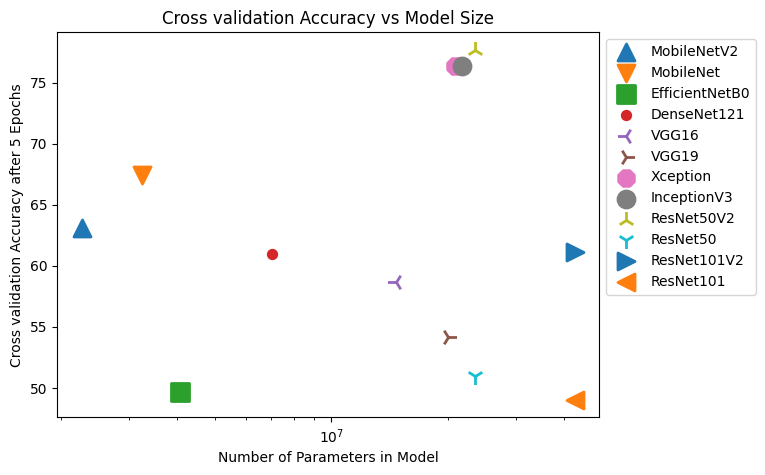

In [ ]:
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Cross validation Accuracy after 5 Epochs')
plt.title('Cross validation Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

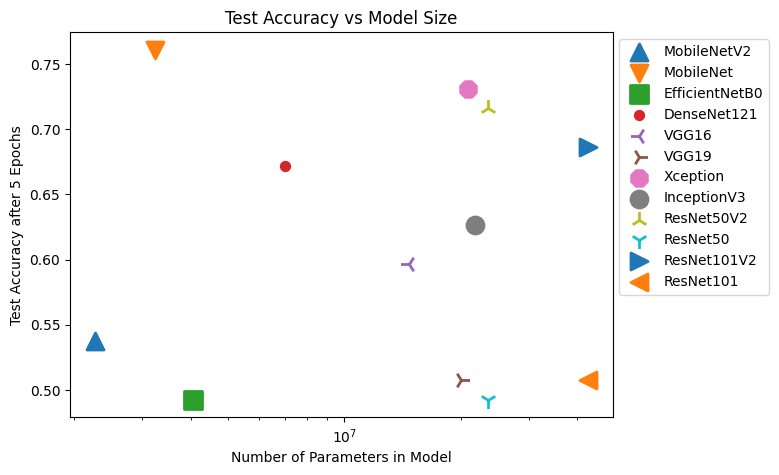

In [ ]:
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.test_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Test Accuracy after 5 Epochs')
plt.title('Test Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot